## Imports

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('libraries')
import signal_processing as spl 
import prediction_lib as pl
pl = reload(pl)
spl = reload(spl)

In [24]:
import IPython

In [25]:
import numpy as np
from bs4 import BeautifulSoup
from collections import Counter
import urllib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from tqdm import tqdm
import sys
from scipy import optimize
from IPython import display
from collections import Counter
from sklearn.externals import joblib

from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from python_speech_features import mfcc

##  Load in Signal DF

In [26]:
load = True
name = 'NOISEY_LABELED_CHARACTER_INPUTS'
INPUT_FILE = 'data/LABELED_CHARACTER_INPUTS.csv' 
out_name = 'results/%s_RESULTS.csv' % name

In [27]:
if load and os.path.exists(out_name):
    RESULTS_DF = pd.read_csv(out_name, index_col = 0)
    RESULTS_DF.head()
else:
    RESULTS_DF = None

In [28]:
char_inps_raw = pd.read_csv(INPUT_FILE, index_col=0)
char_inps_raw['char'] = char_inps_raw['char'].fillna(' ').replace('#SPACE', ' ')
# char_inps_raw['peak_diff'] =char_inps_raw['peak_diff'].fillna(0)
char_inps_raw = char_inps_raw.fillna(0)
char_inps_raw.tail(10)

,index,peak time,signal,start time,end time,char,is_space,peak_diff,0,1,...,16791,16792,16793,16794,16795,16796,16797,16798,16799,16800
1042,1086,596.346667,12875.447266,596.311667,596.661667,b,0,0.270667,18.0,20.0,...,98.0,98.0,-60.0,-27.0,88.0,85.0,46.0,-21.0,-80.0,0.0
1043,1087,596.617333,22127.296875,596.582333,596.932333,b,0,0.149333,17.0,13.0,...,9.0,7.0,6.0,10.0,11.0,10.0,10.0,11.0,9.0,0.0
1044,1088,596.766667,2168.157959,596.731667,597.081667,i,0,0.354667,-5.0,4.0,...,-14.0,-16.0,-17.0,-13.0,-13.0,-21.0,-21.0,-14.0,-14.0,-19.0
1045,1089,597.121333,1214.426758,597.086333,597.436333,t,0,0.294000,26.0,26.0,...,48.0,243.0,253.0,147.0,56.0,-3.0,99.0,157.0,53.0,0.0
1046,1090,597.415333,25453.357422,597.380333,597.730333,,1,1.591333,10.0,6.0,...,-15.0,-15.0,-17.0,-25.0,-28.0,-21.0,-17.0,-21.0,-24.0,0.0
1047,1091,599.006667,6431.091797,598.971667,599.321667,h,0,0.247333,-3.0,-1.0,...,13.0,3.0,-6.0,17.0,10.0,-15.0,2.0,24.0,23.0,28.0
1048,1092,599.254000,3091.520508,599.219000,599.569000,o,0,0.462000,13.0,11.0,...,50.0,41.0,34.0,32.0,28.0,21.0,16.0,13.0,10.0,8.0
1049,1093,599.716000,913.455261,599.681000,600.031000,l,0,0.270667,2.0,4.0,...,40.0,-36.0,-24.0,100.0,-11.0,-66.0,54.0,46.0,41.0,33.0
1050,1094,599.986667,17315.521484,599.951667,600.301667,e,0,0.200667,-13.0,-19.0,...,-17.0,-140.0,-119.0,0.0,59.0,63.0,87.0,89.0,61.0,-7.0
1051,1095,600.187333,5176.197266,600.152333,600.502333,,0,0.000000,-18.0,-13.0,...,-12.0,-11.0,-7.0,-4.0,1.0,8.0,5.0,-1.0,2.0,6.0


In [29]:
targ_s = ''.join(char_inps_raw['char'].values)
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind a well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her there was nothing so very emarkable in that nor did alice think it so very much oh dear i shall be late it occurred to her afterwards she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually toook a watch out of its packet and looked at it and then hurried on alice started to her feet and in another moment down went alice after it never once considering burning how in the 

In [43]:
PARAM_RESULTS ={}

In [44]:
STDEV = char_inps_raw[char_inps_raw.columns[8:]].values.std()

## Processing 

In [45]:
RATE = 44100
WHITEN = True
SAVE_THRESH= 0.45
TOL = 1e-2
NOISE = [1, .5, 1e-1, 1e-2, 1e-3]

should_loop = True


MAX_COLS = -1
MFCC_START = [0]
MFCC_END = [-60]
NUM_CLUSTERS = [50]
N_COMPONENTS = [None, 100]
DO_ALL = False


REPEATS = 24
SMOOTHS = map(lambda x : np.exp(x), range(1,2))

In [52]:
def build_params(smooth, end, start, cluster, comp, noise):
    _id = datetime.datetime.now()
    PARAM_RESULTS[_id] = {'RATE' : RATE,
        'TOL' : TOL,
        'INPUT_FILE' : INPUT_FILE,
         'MAX_COLS': MAX_COLS,
          'NUM_CLUSTERS' : cluster,
          'N_COMPONENTS' : comp,
          'MFCC_START' : start,
          'MFCC_END' : end,
          'WHITEN' : WHITEN,
          'DO_ALL' : DO_ALL,
          'SMOOTH' : smooth,
          'PREDICTION' : None,
          'ACCURACY_WO_SPACES' : None,
         'OVERALL_ACCURACY' : None,
         'SCORE' : None,
         'MODEL' : None,
        'MODEL_FNAME' : None,
            'NOISE' : noise
                          
         }
    return PARAM_RESULTS[_id], _id

def save(model = None, accuracy = None, _id = None):
    global RESULTS_DF
    if model:
        PARAM_RESULTS[_id]['MODEL_FNAME'] = "models/%s-%s.pkl" % (_id, accuracy)
        joblib.dump(model, "models/%s-%s.pkl" % (_id, accuracy))
        
    if RESULTS_DF is not None:
        RESULTS_DF = RESULTS_DF.append(pd.DataFrame(PARAM_RESULTS).T).drop_duplicates()
    else:
        RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
    
    
    
    
    RESULTS_DF.sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending=False).to_csv(out_name)
    
    by_smooth = RESULTS_DF[['ACCURACY_WO_SPACES','OVERALL_ACCURACY', 'SMOOTH']].dropna().astype(float).groupby('SMOOTH')


def loop():
    
    # Copy and take subset
    char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
    
    for _ in range(REPEATS):
        # Extract features
        for end in MFCC_END:
            for start in MFCC_START:
                for cluster in NUM_CLUSTERS:
                    for comp in N_COMPONENTS:
                        for nois in NOISE:
                            cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=start, mfcc_end=end, noise = STDEV * nois)

                            # Cluster the sounds
                            cepstrum_df = pl.cluster(cepstrum_df, num_clusters = cluster, n_components = comp)

                            # Repeat the hmm experiement for each parameter

                            # For each smoothing parameter to be tested
                            for smooth in SMOOTHS:


                                estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                                        cluster, t_smooth = smooth, tol = TOL,
                                                                        do_all = DO_ALL, verbose = False)  
                                print nois, smooth, acc, acc_wospace, score
                                params,_id = build_params(smooth, end, start, cluster, comp, nois)
                                params['OVERALL_ACCURACY'] = acc
                                params['ACCURACY_WO_SPACES'] = acc_wospace
                                params['PREDICTION'] = estimate
                                params['SCORE'] = score
                                params['MODEL'] = hmm

                                if acc > SAVE_THRESH:
                                    save(hmm, acc, _id)
                                else:
                                    save()
if should_loop:
    loop()

,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_END,MFCC_START,MODEL,MODEL_FNAME,NOISE,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,WHITEN
2016-12-02 22:31:02.693378,0.0662722,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.145437,hayof alerguthif it bringe sout bojue bery win...,44100,-3982.35,2.71828,0.01,True
2016-12-02 21:40:14.081554,0.0698225,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.160646,theale linusheanghalid ainbe ave ailly toully ...,44100,-3945,2.71828,0.01,True
2016-12-02 21:05:30.345259,0.0710059,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.157795,ave theve cofick fr he ly chean s ive in ckith...,44100,-3921.15,2.71828,0.01,True
2016-12-02 22:21:11.542146,0.0840237,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.1673,walle couce presthe ithase te and the erok th ...,44100,-3876.34,2.71828,0.01,True
2016-12-02 22:16:07.667364,0.0852071,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.176806,cout aburojur or me th ond qut ofouly thoveshe...,44100,-3868.6,2.71828,0.01,True
2016-12-02 22:52:41.621149,0.0745562,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.180608,he wond fid thong t we ayous nd mppld by vinon...,44100,-3862.97,2.71828,0.01,True
2016-12-02 21:10:25.005055,0.0852071,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.179658,thanghe as g wanthe in bus amavethory pl wondo...,44100,-3859.79,2.71828,0.01,True
2016-12-02 22:26:03.978844,0.105325,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.18251,bere athe ashee ang thite whe theseyoffulldora...,44100,-3858.5,2.71828,0.01,True
2016-12-02 22:46:35.821616,0.0733728,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.176806,wouryonthers ckeery thever tofourexpe orofofic...,44100,-3857.4,2.71828,0.01,True
2016-12-02 21:45:18.018060,0.12071,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,100,0.212928,athe anere sppouced by cke tintoutrknowilingh ...,44100,-3855.76,2.71828,0.01,True


In [61]:
RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
RESULTS_DF.head()

,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_END,MFCC_START,MODEL,MODEL_FNAME,NOISE,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,WHITEN
2016-12-02 21:02:38.488647,0.0686391,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,1,50,None,0.13308,tharshele oullke aid aiche t us f sicemad linl...,44100,-3611.86,2.71828,0.01,True
2016-12-02 21:03:16.750666,0.0556213,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,0.5,50,None,0.128327,wing sthay y he athicerour d cojusuthico qundo...,44100,-3445.6,2.71828,0.01,True
2016-12-02 21:03:50.125842,0.179882,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,0.1,50,None,0.310837,thime did ad herofo st mes thes anged as lingo...,44100,-3635.42,2.71828,0.01,True
2016-12-02 21:04:25.751533,0.262722,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,0.01,50,None,0.391635,avere was hevillind qu ved bero theng ld wiffi...,44100,-3801.54,2.71828,0.01,True
2016-12-02 21:05:11.032374,0.276923,False,data/LABELED_CHARACTER_INPUTS.csv,-1,-60,0,"MultinomialHMM(algorithm='viterbi', init_param...",None,0.001,50,None,0.398289,uplle may bexingine tl the amor thous te tinti...,44100,-3855.79,2.71828,0.01,True


## Compare the different noise levels

In [97]:
result_dict = {}
wk = {}
for noise in set(RESULTS_DF['NOISE']):
    WORK_DF = RESULTS_DF[RESULTS_DF['NOISE'] == noise].sort_values('SCORE')
    wk[noise] = WORK_DF


    # Unique chars are a-z and space
    unique_chars = np.array([' '] + map(lambda x : chr(x + ord('a')), range(26)))

    # Number of unique
    n_unique = len(unique_chars)

    # Map char to id and vice versa
    id_to_char = dict(zip(range(n_unique), unique_chars))
    char_to_id = dict(zip(unique_chars, range(n_unique)))
    results = pd.DataFrame(map(lambda x : np.squeeze(x), WORK_DF['PREDICTION'].map(lambda x : np.array(list(x))).values)).applymap(lambda x : char_to_id[x])

    acc = pl.accuracy(''.join(results.apply(lambda x : Counter(x).most_common(1)[0][0]).map(id_to_char).values), targ_s)
    results.to_csv('Noise-{}-LABLED_CHAR_INPUTS_COMBINED_RESULTS-{}%.csv'.format(noise, round(acc * 100., 3)))
    result_dict[noise] = results

In [ ]:
save()

## Plot accuracy vs white noise

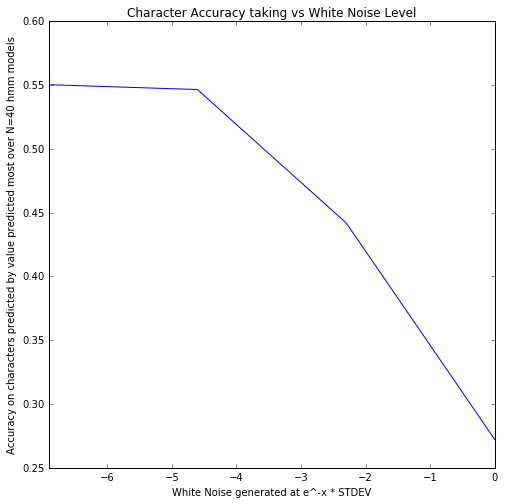

In [95]:
acc = {}
for key in result_dict:
    acc[key] = pl.accuracy(''.join(result_dict[key].apply(lambda x : Counter(x).most_common(1)[0][0]).map(id_to_char).values), targ_s)



acc_series = pd.Series(acc)
acc_series.index = acc_series.index.map(np.log)
acc_series.sort_index().plot(title = 'Character Accuracy taking vs White Noise Level')
ax.set_xlabel('White Noise generated at e^-x * STDEV')
ax.set_ylabel('Accuracy on characters predicted by value predicted most over N=40 hmm models')

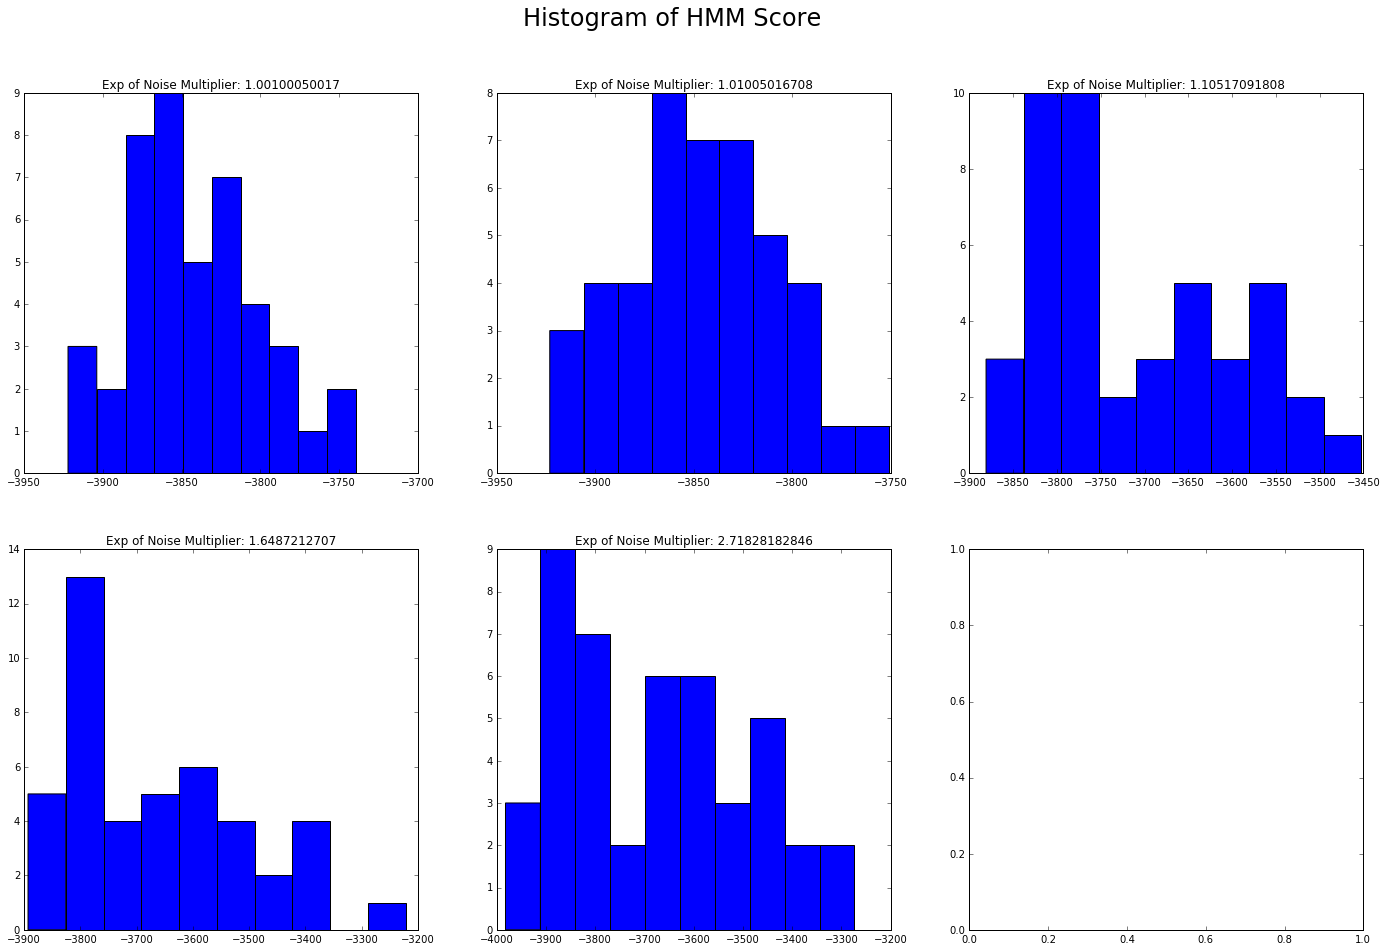

In [142]:
noise_vals = sorted(list(set(RESULTS_DF['NOISE'])))
n = len(noise_vals)
fig, axes = plt.subplots((n-1)/3+1, 3, figsize=(24, n*3))
_ = fig.suptitle('Histogram of HMM Score', fontsize = "24")
# Repeat for each coefficient
for idx, noise in enumerate(noise_vals):
    axe = axes[idx / 3][idx % 3]
    _ = axe.hist(wk[noise]['SCORE'])
    _ = axe.set_title('Exp of Noise Multiplier: ' + str(np.exp(noise)))

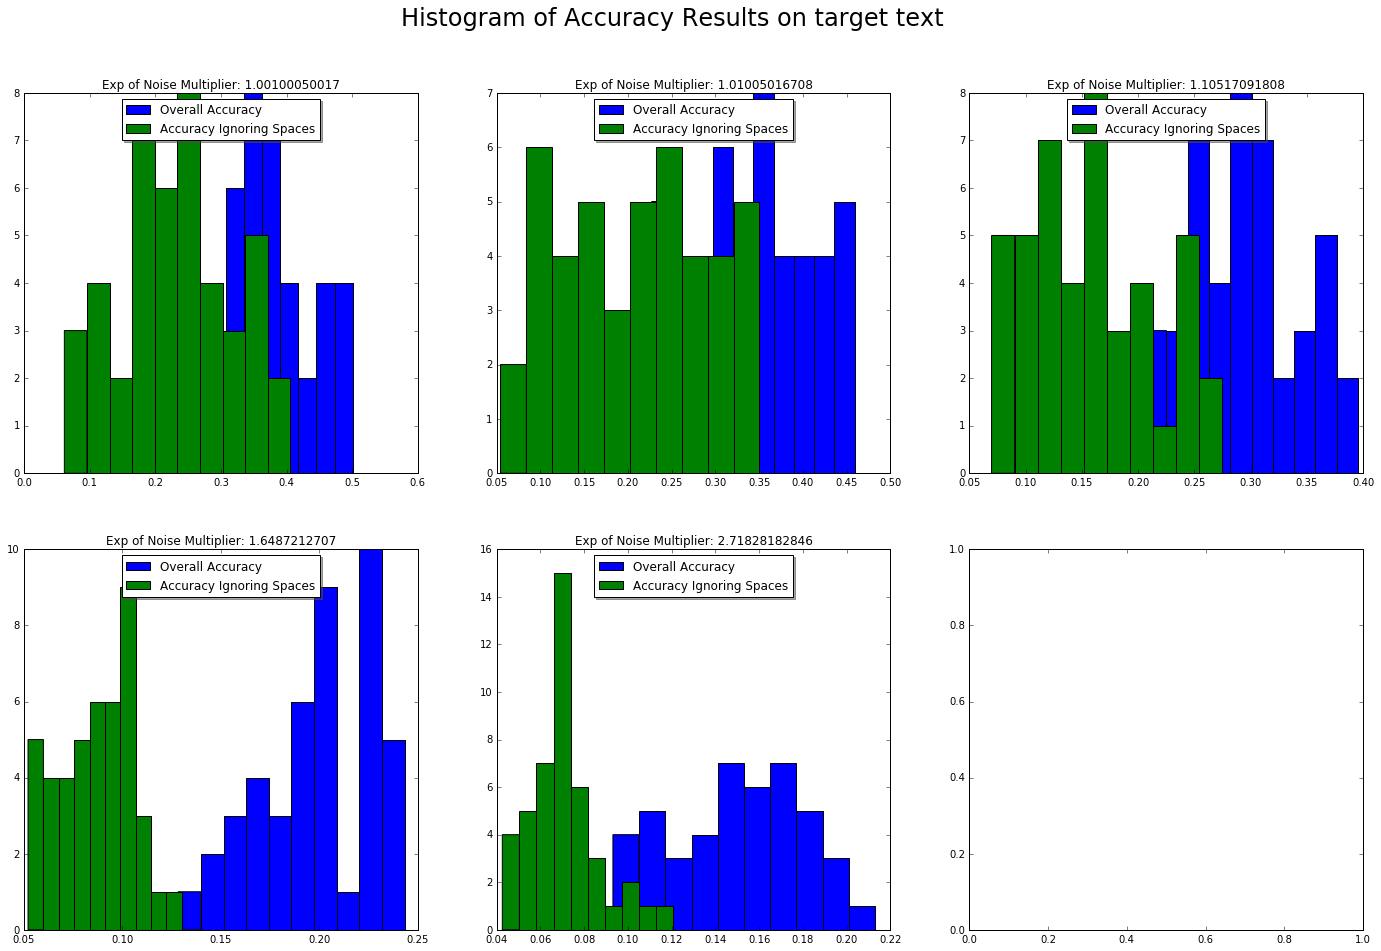

In [147]:
noise_vals = sorted(list(set(RESULTS_DF['NOISE'])))
n = len(noise_vals)
fig, axes = plt.subplots((n-1)/3+1, 3, figsize=(24, n*3))
_ = fig.suptitle('Histogram of Accuracy Results on target text', fontsize = "24")
# Repeat for each coefficient
for idx, noise in enumerate(noise_vals):
    axe = axes[idx / 3][idx % 3]
    _ = axe.hist(wk[noise]['OVERALL_ACCURACY'], label = 'Overall Accuracy')
    _ = axe.hist(wk[noise]['ACCURACY_WO_SPACES'], label = 'Accuracy Ignoring Spaces')
    _ = axe.set_title('Exp of Noise Multiplier: ' + str(np.exp(noise)))
    _ = axe.legend(loc='upper center', shadow=True)
    